Pleural Effusion Classifier

In [1]:
import time
import platform
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader

print("python version:", platform.python_version())
print("torch version:", torch.__version__)
print("torch cuda:", torch.cuda.is_available())
print("torch cuda version", torch.version.cuda)
gpu=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

python version: 3.7.7
torch version: 1.6.0
torch cuda: True
torch cuda version 10.2


In [11]:
# dataset = torchvision.datasets.ImageFolder(
#     root = 'dataset/training_set/',
#     transform = transforms.Compose([
#     transforms.Resize((224 ,224))
#     ,transforms.ToTensor()
# ]))

# dataset_loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size = 32
# )

In [12]:
# def get_mean_std(loader):
#     channels_sum, channels_squared_sum, batch_size = 0, 0, 0
#     for data, _ in loader:
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         batch_size += 1
#     mean = channels_sum/batch_size
#     std = channels_squared_sum/batch_size
#     return mean, std

In [13]:
# mean, std = get_mean_std(dataset_loader)
# print("training set mean is: ", mean)
# print("training set std is: ", std)

# # imagenet mean and std
# # mean = [0.485, 0.456, 0.406]
# # std = [0.229, 0.224, 0.225]

training set mean is:  tensor([0.4952, 0.4952, 0.4952])
training set std is:  tensor([0.3148, 0.3148, 0.3148])


In [4]:
train_path = 'dataset/training_set/'
validation_path = 'dataset/validation_set/'
train_transforms = transforms.Compose([
    transforms.Resize((224, 224))
    ,transforms.RandomHorizontalFlip()
    ,transforms.ToTensor()
    ,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224))
    ,transforms.ToTensor()
    ,transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
train_data = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = train_transforms
)
validation_data = torchvision.datasets.ImageFolder(
    root = validation_path,
    transform = val_transforms
)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_data
    ,batch_size=16
    ,shuffle=True
    ,num_workers=1
    ,pin_memory=True
)
validation_loader = torch.utils.data.DataLoader(
    validation_data
    ,batch_size=16
    ,shuffle=False
    ,num_workers=1
    ,pin_memory=True
)

In [7]:
print("Classes : ", train_data.class_to_idx)
print("Number of Training Samples : ", len(train_data))
print("Number of Validation Samples : ", len(validation_data))

Classes :  {&#39;Effusion&#39;: 0, &#39;No Finding&#39;: 1}
Number of Training Samples :  2000
Number of Validation Samples :  250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Label : Effusion


&lt;matplotlib.image.AxesImage at 0x2957e581308&gt;

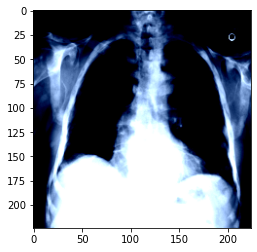

In [8]:
# plot sample image
sample = next(iter(train_data))
image, label = sample
image.shape

if label == 0:
    label = "Effusion"
else :
    label = "No Finding"
print("Label :", label)

image = np.transpose(image, (1,2,0))
plt.imshow(image)

In [9]:
batch = next(iter(train_loader))
images, labels = batch
print(images.shape)
print(labels.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels : tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1])


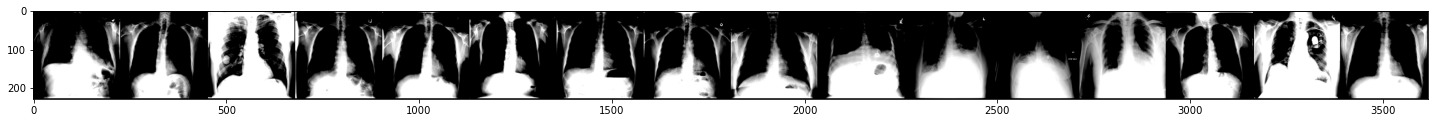

In [48]:
# normalized with training set mean and std
grid = torchvision.utils.make_grid(images, nrow = 16)

plt.figure(figsize = (25,25))
plt.imshow(np.transpose(grid, (1,2,0)))
print("Labels :", labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Labels : tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1])


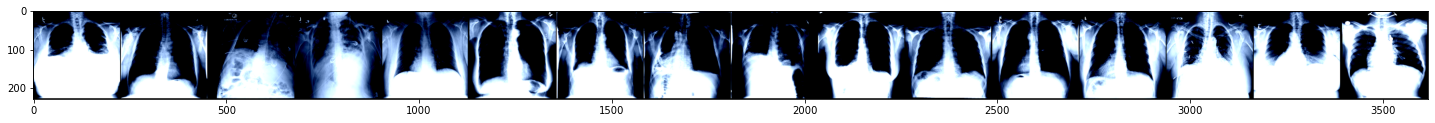

In [10]:
# normalized with imagenet mean and std
grid = torchvision.utils.make_grid(images, nrow = 16)

plt.figure(figsize = (25,25))
plt.imshow(np.transpose(grid, (1,2,0)))
print("Labels :", labels)

In [11]:
# the model
model = models.vgg19(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - total_trainable_params
print('Total Parameters: ',total_params)
print('Total Trainable Parameters: ',total_trainable_params)
print('Total Non Trainable Parameters: ',non_trainable_params)

Total Parameters:  143667240
Total Trainable Parameters:  143667240
Total Non Trainable Parameters:  0


In [13]:
for param in model.features.parameters():
    param.requires_grad=False

In [14]:
import torch.nn as nn

conv28 = nn.Conv2d(512, 512, 3, 1)
conv30 = nn.Conv2d(512, 512, 3, 1)
conv32 = nn.Conv2d(512, 512, 3, 1)
conv34 = nn.Conv2d(512, 512, 3, 1)

gap = nn.AdaptiveAvgPool2d((1, 1))
first_fc_layer = nn.Linear(512, 1024)
second_fc_layer = nn.Linear(1024, 1024)
last_fc_layer = nn.Linear(1024, 2)
do1 = torch.nn.Dropout(p = 0, inplace=False)
do2 = torch.nn.Dropout(p = 0, inplace=False)

model.avgpool = gap
model.classifier[0] = first_fc_layer
model.classifier[3] = second_fc_layer
model.classifier[6] = last_fc_layer
model.classifier[2] = do1
model.classifier[5] = do2

model.features[28] = conv28
model.features[30] = conv30
model.features[32] = conv32
model.features[34] = conv34

model.to(gpu)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
total_params = sum(p.numel() for p in model.parameters())
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - total_trainable_params
print('Total Parameters: ',total_params)
print('Total Trainable Parameters: ',total_trainable_params)
print('Total Non Trainable Parameters: ',non_trainable_params)

Total Parameters:  21601346
Total Trainable Parameters:  11016194
Total Non Trainable Parameters:  10585152


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [17]:
loss_history = []
corrects_history = []
val_loss_history = []
val_corrects_history = []
val_loss_min = np.inf

for epoch in range(50): 
    
    t0 = time.time()
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    model.train()
    for images,labels in train_loader:
        images = images.to(gpu)
        labels = labels.to(gpu)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    else:
        model.eval()
        with torch.no_grad():
            for val_images,val_labels, in validation_loader:
                val_images = val_images.to(gpu)
                val_labels = val_labels.to(gpu)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                
                val_running_loss += val_loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss=running_loss/len(train_loader.dataset)
    epoch_acc=running_corrects.float()/len(train_loader.dataset) 
    loss_history.append(epoch_loss)
    corrects_history.append(epoch_acc)

    val_epoch_loss=val_running_loss/len(validation_loader.dataset)
    val_epoch_acc=val_running_corrects.float()/len(validation_loader.dataset) 
    val_loss_history.append(val_epoch_loss)
    val_corrects_history.append(val_epoch_acc)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
        }
    
    # saving model every epoch
    # torch.save(checkpoint, r'checkpoint\vgg19gap_epoch_{}.pth'.format(epoch + 1))

    print('----------------------------------------------------------------')
    print('epoch: ', (epoch + 1))   
    print('----------------------------------------------------------------')
    print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
    print('epoch time: {:.4f} seconds'.format(time.time() - t0))
    
    if val_epoch_loss <= val_loss_min:
        print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min, val_epoch_loss))
        torch.save(checkpoint, r'checkpoint\vgg19gap_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
        val_loss_min = val_epoch_loss

----------------------------------------------------------------
epoch:  1
----------------------------------------------------------------
training loss: 0.0290, acc: 0.7710
validation loss: 0.0142, acc: 0.9320
epoch time: 132.1171 seconds
validation loss decreased from inf to 0.0142, saving model...
----------------------------------------------------------------
epoch:  2
----------------------------------------------------------------
training loss: 0.0177, acc: 0.9000
validation loss: 0.0184, acc: 0.8800
epoch time: 126.9816 seconds
----------------------------------------------------------------
epoch:  3
----------------------------------------------------------------
training loss: 0.0150, acc: 0.9205
validation loss: 0.0158, acc: 0.8960
epoch time: 119.8720 seconds
----------------------------------------------------------------
epoch:  4
----------------------------------------------------------------
training loss: 0.0117, acc: 0.9315
validation loss: 0.0154, acc: 0.9120
epo

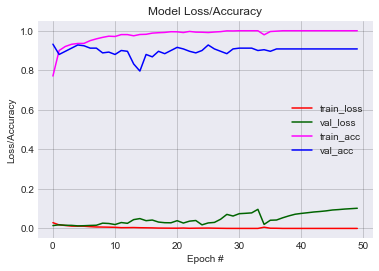

In [18]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(loss_history, color = 'red')
plt.plot(val_loss_history, color = 'darkgreen')
plt.plot(corrects_history, color = 'magenta')
plt.plot(val_corrects_history, color = 'blue')
plt.title('Model Loss/Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss', 'train_acc', 'val_acc'], loc = 'center right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
plt.savefig(r'graphs\vgg19gap_acc_loss.png', dpi = 100)

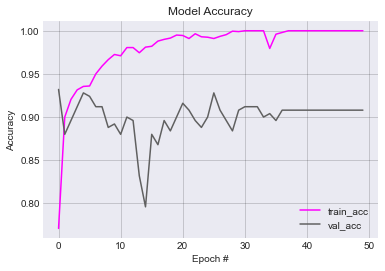

In [19]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(corrects_history, color = 'magenta')
plt.plot(val_corrects_history, color = '#606060')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_acc', 'val_acc'], loc = 'lower right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
plt.savefig(r'graphs\vgg19gap_acc.png', dpi = 100)

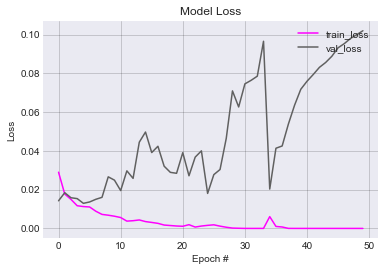

In [20]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(loss_history, color = 'magenta')
plt.plot(val_loss_history, color = '#606060')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
plt.savefig(r'graphs\vgg19gap_loss.png', dpi = 100)

In [22]:
# torch.save(model.state_dict(), r'model\vgg19gap.pth')